In [12]:
import csv
import numpy as np
import utils
import hrr_utils
import time


from scipy import spatial

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline


N=1000

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def train(tv, past, present):
    tv += np.multiply(past, present)
    return tv

def reg_train(tv, past, present):
    pred = np.multiply(tv, present)
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past))/float(N)) * np.multiply(past, present)
    return tv

def train_diff(tv, past2, present1, present2):
    tv += np.multiply(present1, past2-present2)
    return tv

def reg_train_diff(tv, past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)
    return tv

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, y1std, y2std, ylims=[], title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(rotation=45)
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])
    plt.ylim(ylims)

    plt.tight_layout()
# https://matplotlib.org/api/lines_api.html
def graph_separate(x, y1, y2, y1std, y2std, \
                   y1regular, y1irregular, y2regular, y2irregular, \
                   ylims=[], title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   

    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(rotation=45)
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')
    plt.plot(x, y1regular, '--', c='b', lw=2, label='Train')
    plt.plot(x, y1irregular, ':', c='b', lw=2, label='Train')
    plt.plot(x, y2regular, '--', c='g', lw=2, label='Test')
    plt.plot(x, y2irregular, ':', c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])
    plt.ylim(ylims)

    plt.tight_layout()


In [13]:
reload(utils)

<module 'utils' from 'utils.pyc'>

In [14]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2/3.0

irregular_train_idx = int(train_frac*len(irreg_pres))
train_irreg = irregular[0:irregular_train_idx]

regular_train_idx = 1700 - len(train_irreg) 
train_reg = regular[0:regular_train_idx]

test_reg = regular[regular_train_idx:]
test_irreg = irregular[irregular_train_idx:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

# regular.extend(irregular)
# verbs = regular

In [15]:
print("training set size", len(train_reg), len(train_irreg))
print ("test set size", len(test_reg), len(test_irreg))


('training set size', 1574, 126)
('test set size', 874, 63)


In [16]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

figures/LowRankSolver-unregularized_trigam_dict-N=1000-W=1700-170503


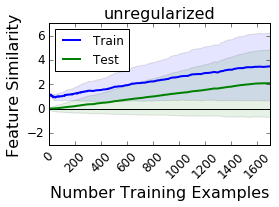

In [20]:
psi = np.zeros(N)
psi = train(psi, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0]+1, 1)
y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])

y1regular = np.zeros(trainpres1.shape[0])
y1irregular = np.zeros(trainpres1.shape[0])
y2regular = np.zeros(trainpres1.shape[0])
y2irregular = np.zeros(trainpres1.shape[0])

for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    regularsim1 = sim1[np.arange(0,min(k,regular_train_idx),1)]
    if k > regular_train_idx:
        irregularsim1 = sim1[regular_train_idx:]
    else:
        irregularsim1 = np.zeros(sim1.shape)
        
    regularsim2 = sim2[:len(test_reg)]
    irregularsim2 = sim2[len(test_reg):]
    
    y1[k] = sim1.mean()/N
    y1std[k] = np.nanstd(sim1, axis=0)/N #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()/N
    y2std[k] = sim2.std(axis=0)/N #/ testpast2.shape[0]**0.5
    
    y1regular[k] = regularsim1.mean()/N
    y1irregular[k] = irregularsim1.mean()/N
    y2regular[k] = regularsim2.mean()/N
    y2irregular[k] = irregularsim2.mean()/N

    psi = train(psi, trainpast2[k], trainpres1[k])

graph(x,y1,y2,y1std,y2std,ylims=[-3,7],title="unregularized",legend="upper left")

fname =  ('figures/LowRankSolver-unregularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


((1700,), (1700,), (1700,), (1700,))
figures/LowRankSolver-separated-unregularized_trigam_dict-N=1000-W=1700-170503


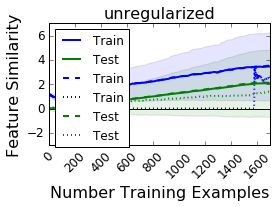

In [22]:
print(y1regular.shape, y1irregular.shape, y2regular.shape, y2irregular.shape,)
graph_separate(x, y1, y2, y1std, y2std, \
                   y1regular, y1irregular, y2regular, y2irregular, \
                   ylims=[-3,7],title="unregularized",legend="upper left")  

fname =  ('figures/LowRankSolver-separated-unregularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
      + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/LowRankSolver-regularized_trigam_dict-N=1000-W=1889-170502


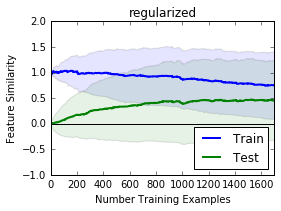

In [22]:
psi = np.zeros(N)
psi = reg_train(psi, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0]+1, 1)
y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])
for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[k] = sim1.mean()/N
    y1std[k] = np.nanstd(sim1, axis=0)/N #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()/N
    y2std[k] = sim2.std(axis=0)/N #/ testpast2.shape[0]**0.5
    
    psi = reg_train(psi, trainpast2[k], trainpres1[k])

graph(x,y1,y2,y1std,y2std,ylims=[-1,2],title="regularized",legend="lower right")

fname =  ('figures/LowRankSolver-regularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)



ValueError: too many values to unpack

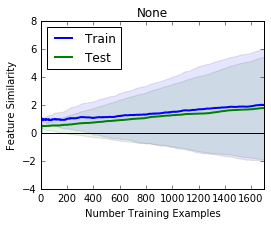

In [15]:
psi = np.zeros(N)
psi = train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0]+1, 1)
y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])

for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[k] = sim1.mean()/N
    y1std[k] = np.nanstd(sim1, axis=0)/N #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()/N
    y2std[k] = sim2.std(axis=0)/N #/ testpast2.shape[0]**0.5
    
    psi = train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,y1std,y2std,ylims=[-3,7],"diff-unregularized")

fname =  ('figures/LowRankSolver-diff_unregularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


figures/LowRankSolver-diff_regularized_trigam_dict-N=10000-W=1889-170427


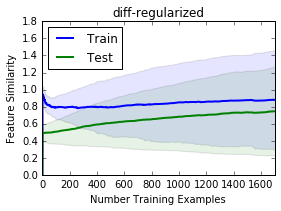

In [24]:
psi = np.zeros(N)
psi = reg_train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0]+1, 1)
y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])

for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[k] = sim1.mean()/N
    y1std[k] = np.nanstd(sim1, axis=0)/N #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()/N
    y2std[k] = sim2.std(axis=0)/N #/ testpast2.shape[0]**0.5
    
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,y1std,y2std,ylims=[-1,2],"diff-regularized")


fname =  ('figures/LowRankSolver-diff_regularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)
